In [1]:
%gui qt

import napari
from napari.utils import io

from scipy.stats import linregress

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from openpiv import tools, process, validation, filters, scaling


In [2]:

winsize = 8 # pixels
searchsize = 24  # pixels, search in image B
overlap = 4 # pixels
dt = 1.0 # sec



In [3]:
def do_piv(im_path):
    images = io.imread(im_path)
    myosn = images
#     juncs = images[..., 0].mean(axis=0)
    uus = []
    vvs = []
    snr = []
    

    for i in range(myosn.shape[0]-1):

        frame_a, frame_b = myosn[[i, i+1]]
        u0, v0, sig2noise = process.extended_search_area_piv(
            frame_a.astype(np.int32),
            frame_b.astype(np.int32),
            window_size=winsize,
            overlap=overlap,
            dt=dt,
            search_area_size=searchsize,
            sig2noise_method='peak2peak'
        )
        u1, v1, mask = validation.sig2noise_val(
            u0,
            v0,
            sig2noise,
            threshold = 1.1#1.1
        )
        
        uus.append(u1)
        vvs.append(v1)
        snr.append(sig2noise)

    x, y = process.get_coordinates(
        image_size=frame_a.shape,
        window_size=winsize,
        overlap=overlap
    )


    uu = np.array(uus)
    vv = np.array(vvs)
    snr = np.array(snr)

    xx = np.tile(x, (uu.shape[0], 1)).reshape(uu.shape)
    yy = np.tile(y, (uu.shape[0], 1)).reshape(uu.shape)
    
    res = {"X": xx, "Y": yy, "U": uu, "V": vv, "SNR": snr, "IMG": images.mean(axis=0)}
    return res



In [4]:
def plot_all(piv_result, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = ax.get_figure()
        
    xx = piv_result["X"].ravel()
    yy = piv_result["Y"].ravel()
    uu = piv_result["U"].ravel()
    vv = piv_result["V"].ravel()
    snr = piv_result["SNR"].ravel()
    img = piv_result["IMG"]

    ax.imshow(img, cmap=plt.cm.gray_r)
    ax.quiver(
        xx,
        yy,
        uu,
        vv,
        snr,
        scale=5.,
        scale_units='x',
        angles="xy",
    )
    return fig, ax


In [63]:
def plot_average(piv_result, ax=None):

    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = ax.get_figure()
    x = piv_result["X"][0]
    y = piv_result["Y"][0]
    uu = piv_result["U"].copy()
    vv = piv_result["V"].copy()
    snr = piv_result["SNR"]

    uu[~np.isfinite(uu)] = 0
    vv[~np.isfinite(vv)] = 0
    
#     mean_uu  = np.average(uu, axis=0, weights=(snr-1))
#     mean_vv  = np.average(vv, axis=0, weights=(snr-1))

    mean_uu = np.mean(uu, axis=0)
    mean_vv = np.mean(vv, axis=0)
    
    mean_snr = np.mean(snr, axis=0)
    
    img = piv_result["IMG"]
    ax.imshow(img, cmap=plt.cm.gray_r)
    ax.quiver(
        x, y, mean_uu, mean_vv, 
        mean_snr, 
        scale=1.5,
        #scale=1,
        scale_units='x',
        angles="xy",
    )
    return fig, ax

/home/admin-suz/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in double_scalars
/home/admin-suz/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log


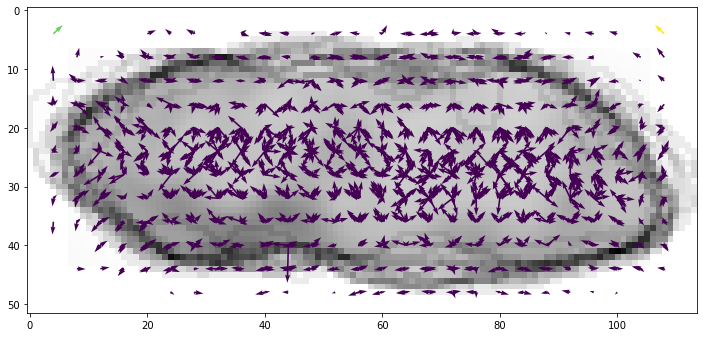

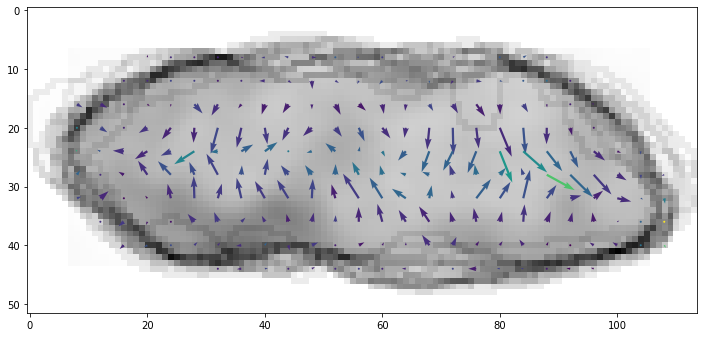

In [95]:
dirname = "PIV-Guillaume-Christian-Sophie/ctl/leg1-ctl/cells/"

name = "roi3"
piv_result = do_piv(dirname+name+".tif")

fig, ax = plot_average(piv_result, ax=None)
fig.set_size_inches(12, 12)
fig.savefig(dirname+name+'_mean.eps', dpi=300)

In [137]:
from pathlib import Path
all_horiz = []
ax = None
name = 'roi*.tif'
# cond = 'Arpc5i'
cond = 'ctl'

col = ["name", "x", "y", "u", "v", "snr", "theta", "dist"]
res_df = pd.DataFrame(columns=col)
pos=0
for im in Path('PIV-Guillaume-Christian-Sophie/'+cond+'/leg1-'+cond+'/cells').glob(name):
    print(im)
    piv_result = do_piv(im)
   
    uu = piv_result["U"].copy()
    vv = piv_result["V"].copy()

    uu[~np.isfinite(uu)] = 0
    vv[~np.isfinite(vv)] = 0
    mean_uu = np.mean(uu, axis=0)
    mean_vv = np.mean(vv, axis=0)

    for i in range(len(np.mean(piv_result["X"], axis=0).ravel())):
        tmp = {
                   "name" : im,
                   "x" : np.mean(piv_result["X"], axis=0).ravel()[i],
                   "y" : np.mean(piv_result["Y"], axis=0).ravel()[i],
                   "u" : mean_uu.ravel()[i],
                   "v" : mean_vv.ravel()[i],
                   "snr" : np.mean(piv_result["SNR"], axis=0).ravel()[i],
                   "theta" : (np.arctan2(mean_vv, mean_uu)*180/np.pi).ravel()[i],
                   "dist" : np.sqrt(np.mean(piv_result["X"], axis=0)**2 + np.mean(piv_result["Y"], axis=0)**2).ravel()[i],
                  }

        res_df.loc[pos]=tmp
        pos+=1
    all_horiz.append(piv_result)
    
for im in Path('PIV-Guillaume-Christian-Sophie/'+cond+'/leg2-'+cond+'/cells').glob(name):
    print(im)
    piv_result = do_piv(im)
   
    uu = piv_result["U"].copy()
    vv = piv_result["V"].copy()

    uu[~np.isfinite(uu)] = 0
    vv[~np.isfinite(vv)] = 0
    mean_uu = np.mean(uu, axis=0)
    mean_vv = np.mean(vv, axis=0)

    for i in range(len(np.mean(piv_result["X"], axis=0).ravel())):
        tmp = {
                   "name" : im,
                   "x" : np.mean(piv_result["X"], axis=0).ravel()[i],
                   "y" : np.mean(piv_result["Y"], axis=0).ravel()[i],
                   "u" : mean_uu.ravel()[i],
                   "v" : mean_vv.ravel()[i],
                   "snr" : np.mean(piv_result["SNR"], axis=0).ravel()[i],
                   "theta" : (np.arctan2(mean_vv, mean_uu)*180/np.pi).ravel()[i],
                   "dist" : np.mean(np.sqrt(piv_result["X"], axis=0)**2 + np.mean(piv_result["Y"], axis=0)**2).ravel()[i],
                  }

        res_df.loc[pos]=tmp
        pos+=1
    all_horiz.append(piv_result)

for im in Path('PIV-Guillaume-Christian-Sophie/'+cond+'/leg3-'+cond+'/cells').glob(name):
    print(im)
    piv_result = do_piv(im)
   
    uu = piv_result["U"].copy()
    vv = piv_result["V"].copy()

    uu[~np.isfinite(uu)] = 0
    vv[~np.isfinite(vv)] = 0
    mean_uu = np.mean(uu, axis=0)
    mean_vv = np.mean(vv, axis=0)

    for i in range(len(np.mean(piv_result["X"], axis=0).ravel())):
        tmp = {
                   "name" : im,
                   "x" : np.mean(piv_result["X"], axis=0).ravel()[i],
                   "y" : np.mean(piv_result["Y"], axis=0).ravel()[i],
                   "u" : mean_uu.ravel()[i],
                   "v" : mean_vv.ravel()[i],
                   "snr" : np.mean(piv_result["SNR"], axis=0).ravel()[i],
                   "theta" : (np.arctan2(mean_vv, mean_uu)*180/np.pi).ravel()[i],
                   "dist" : np.mean(np.sqrt(piv_result["X"], axis=0)**2 + np.mean(piv_result["Y"], axis=0)**2).ravel()[i],
                  }

        res_df.loc[pos]=tmp
        pos+=1
    all_horiz.append(piv_result)

for im in Path('PIV-Guillaume-Christian-Sophie/'+cond+'/leg4-'+cond+'/cells').glob(name):
    print(im)
    piv_result = do_piv(im)
   
    uu = piv_result["U"].copy()
    vv = piv_result["V"].copy()

    uu[~np.isfinite(uu)] = 0
    vv[~np.isfinite(vv)] = 0
    mean_uu = np.mean(uu, axis=0)
    mean_vv = np.mean(vv, axis=0)

    for i in range(len(np.mean(piv_result["X"], axis=0).ravel())):
        tmp = {
                   "name" : im,
                   "x" : np.mean(piv_result["X"], axis=0).ravel()[i],
                   "y" : np.mean(piv_result["Y"], axis=0).ravel()[i],
                   "u" : mean_uu.ravel()[i],
                   "v" : mean_vv.ravel()[i],
                   "snr" : np.mean(piv_result["SNR"], axis=0).ravel()[i],
                   "theta" : (np.arctan2(mean_vv, mean_uu)*180/np.pi).ravel()[i],
                   "dist" : np.sqrt(np.mean(piv_result["X"], axis=0)**2 + np.mean(piv_result["Y"], axis=0)**2).ravel()[i],
                  }

        res_df.loc[pos]=tmp
        pos+=1
    all_horiz.append(piv_result)
    
res_df.loc[res_df['theta']<0, "theta"] += 360
res_df.snr[~np.isfinite(res_df.snr)] = 0
res_df = res_df[res_df.snr != 0]



PIV-Guillaume-Christian-Sophie/ctl/leg1-ctl/cells/roi4.tif


/home/admin-suz/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in double_scalars
/home/admin-suz/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log


PIV-Guillaume-Christian-Sophie/ctl/leg1-ctl/cells/roi1.tif
PIV-Guillaume-Christian-Sophie/ctl/leg1-ctl/cells/roi7.tif
PIV-Guillaume-Christian-Sophie/ctl/leg1-ctl/cells/roi3.tif
PIV-Guillaume-Christian-Sophie/ctl/leg1-ctl/cells/roi2.tif
PIV-Guillaume-Christian-Sophie/ctl/leg2-ctl/cells/roi4.tif
PIV-Guillaume-Christian-Sophie/ctl/leg2-ctl/cells/roi1.tif
PIV-Guillaume-Christian-Sophie/ctl/leg2-ctl/cells/roi6.tif
PIV-Guillaume-Christian-Sophie/ctl/leg2-ctl/cells/roi3.tif
PIV-Guillaume-Christian-Sophie/ctl/leg3-ctl/cells/roi4.tif
PIV-Guillaume-Christian-Sophie/ctl/leg3-ctl/cells/roi6.tif
PIV-Guillaume-Christian-Sophie/ctl/leg3-ctl/cells/roi5.tif
PIV-Guillaume-Christian-Sophie/ctl/leg3-ctl/cells/roi3.tif
PIV-Guillaume-Christian-Sophie/ctl/leg4-ctl/cells/roi2.tif


/home/admin-suz/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:124: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [138]:
#res_ctl = res_df.copy()
#res_ctl.to_csv('ctl_all.csv')

# res_arp = res_df.copy()
# res_arp.to_csv('arp_all.csv')

In [92]:
res_df = pd.read_csv("ctl_all.csv")

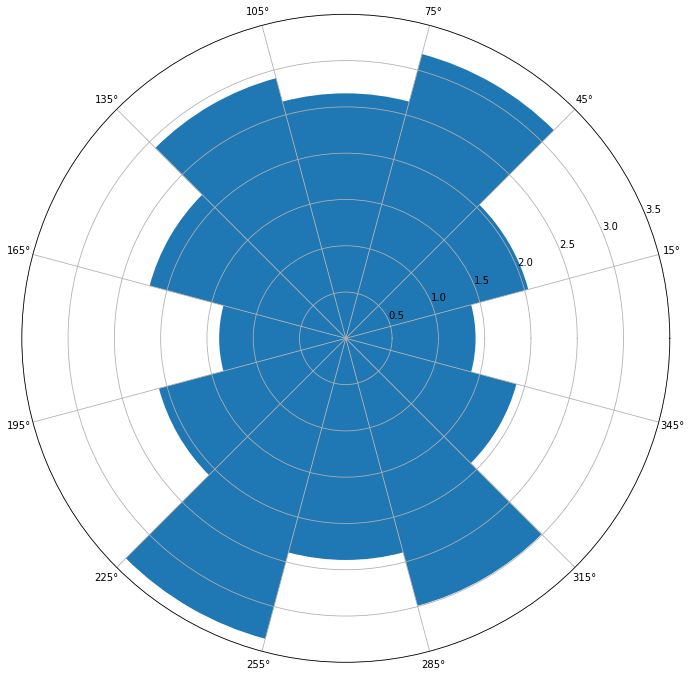

In [93]:
res_df.loc[res_df['theta']<0, "theta"] += 360
res_df = res_df[res_df.snr != 0]

middle = 15
angle_ = list(np.linspace(15, 315, 11)+middle)
dist = []
count = []
for i in range (len(angle_)):
    dist.append(res_df[(angle_[i]-middle<res_df.theta) & (res_df.theta<=angle_[i]+middle)]['dist'].mean())
    count.append(len(res_df[(angle_[i]-middle<res_df.theta) & (res_df.theta<=angle_[i]+middle)]['dist']))
dist.append(res_df[(345<res_df.theta) | (res_df.theta<=15)]['dist'].mean())
count.append(len(res_df[(345<res_df.theta) | (res_df.theta<=15)]['dist']))
angle_.append(345)

df = pd.DataFrame(data = np.array([list(angle_), dist]).T, 
                 columns = ["theta", "dist"])
df['count']=count
# df.dropna(axis=0, inplace=True)
df.replace(np.NaN, 0, inplace=True)
width = np.pi*2/12

fig = plt.figure(figsize=(12,12))
ax = fig.add_axes([0.1, 0.1, 0.75, 0.79], polar=True)

bars = ax.bar((np.arange(0,2*np.pi,2*np.pi/12)+15/180*np.pi)+np.pi/12,
       df['dist'],
       width=width, 
       bottom = 0.0)
ax.set_thetagrids([15, 45, 75, 105, 135, 165, 195, 225, 255, 285, 315, 345])
ax.set_ylim(0, 3.5)
# plt.show()

plt.savefig('ctl_all_dist_corr.eps', dpi=300)
# plt.close(fig)